# Cài đặt thư viện và import thư viện cần thiết

In [1]:
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn
!pip install joblib  # hỗ trợ huấn luyện song song mô hình

# công cụ hỗ trợ từ Hugging Face
!pip install datasets
!pip install transformers
!pip install accelerate
!pip install gradio # cung cấp UI, demo sản phẩm

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import torch
import unicodedata

print("check import")

check import


# Import dataset news/categories

In [3]:
from datasets import load_dataset

ds = load_dataset("phucnn/news-categories")
print(ds)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/107 [00:00<?, ?B/s]

news_categories.csv:   0%|          | 0.00/195M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/46678 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['cat', 'content'],
        num_rows: 46678
    })
})


In [4]:
ds["train"][1]

{'cat': '__label__âm_nhạc',
 'content': 'những sao việt hóa_thân thành phó nháy trong mv nhạc_việt zing vn miu_lê tiêu_châu_như_quỳnh phùng_ngọc_huy đều chọn hình_tượng nhiếp_ảnh_gia khi xuất_hiện trong sản_phẩm riêng những sao việt hóa_thân thành phó nháy trong mv miu_lê tiêu_châu_như_quỳnh phùng_ngọc_huy đều chọn hình_tượng nhiếp_ảnh_gia khi xuất_hiện trong sản_phẩm riêng miu lê trong lặng thầm yêu lặng_thầm yêu là một trong những mv đánh_dấu sự trưởng_thành của miu_lê trong năm 2012 trong sản_phẩm này cô hóa_thân thành một nàng nhiếp_ảnh_gia xinh_đẹp và cá_tính công_việc dường_như chỉ dành cho phái_mạnh này đã khiến cô có cơ_duyên gặp_gỡ tình_yêu của mình hot boy tuấn_kiệt sau những lần chụp ảnh cho anh cô đã đem_lòng yêu chàng hot boy với nụ_cười tỏa nắng này tuy_nhiên khoảng_cách giữa hai người quá lớn miu lê chỉ là một cô_gái làm nghề nhiếp_ảnh cá_tính còn tuấn_kiệt lại là một hot boy điển_trai với tương_lai rộng_mở điều quan_trọng nhất là trước khi biết cô nhiếp_ảnh chàng_trai đ

In [5]:
ds["train"].features

{'cat': Value('string'), 'content': Value('string')}

In [6]:
# Chuyển toàn bộ split sang DataFrame (map content ->text, cat ->label)
def clean_label(s: str) -> str:
    s = str(s)
    if s.startswith("__label__"):
        s = s[len("__label__"):]
    return s.replace("_", " ").strip()

In [7]:
dfs = []
for split in ds.keys():
    dsplit = ds[split].to_pandas()
    # Đặt tên cột
    if "content" not in dsplit.columns or "cat" not in dsplit.columns:
        raise ValueError(list(dsplit.columns))
    dsplit = dsplit.rename(columns={"content": "text", "cat": "label"})
    # Chuẩn hóa nhãn
    dsplit["label"] = dsplit["label"].astype(str).apply(clean_label)
    dsplit["text"] = dsplit["text"].astype(str)
    dsplit["split"] = split
    dfs.append(dsplit[["text", "label", "split"]])

df_ready = pd.concat(dfs, ignore_index=True)


In [8]:
print("df_ready shape:", df_ready.shape)
print(df_ready["split"].value_counts())
print("Số nhãn:", df_ready["label"].nunique())
print("Nhãn:", sorted(df_ready["label"].unique())[:10])


df_ready shape: (46678, 3)
split
train    46678
Name: count, dtype: int64
Số nhãn: 18
Nhãn: ['công nghệ', 'du lịch', 'giáo dục', 'giải trí', 'kinh doanh', 'nhịp sống', 'phim ảnh', 'pháp luật', 'sống trẻ', 'sức khỏe']


In [9]:
df_ready.head(10)

,text,label,split
0,sanchez không dự trận khai màn nh anh cùng ars...,thể thao,train
1,những sao việt hóa_thân thành phó nháy trong m...,âm nhạc,train
2,vợ phải quỳ gối mới được nói_chuyện cười zing ...,nhịp sống,train
3,lumia 520 sẽ có giá 3 9 triệu đồng tại việt_na...,công nghệ,train
4,hà_nội t t chốt danh_sách dự afc cup thể_thao ...,thể thao,train
5,vụ xe điên gây tai_nạn ở sài_gòn tài_xế bị tâm...,thời sự,train
6,lính nga nhảy_dù xuống tảng băng trôi trên bắc...,thế giới,train
7,ngắm vĩnh_thụy đầy chất chơi thời_trang zing v...,thời trang,train
8,bố_mẹ dừng tàu lượn siêu_tốc vì lo cho con_gái...,du lịch,train
9,cụ bà 84 tuổi đặc_trị bệnh chó dại thời_sự zin...,thời sự,train


In [10]:
out_csv = "news_categories_raw.csv"
df_ready.to_csv(out_csv, index=False, encoding="utf-8")
print("ĐÃ LƯU:", out_csv)

ĐÃ LƯU: news_categories_raw.csv


#Tiền xử lý dữ liệu và EDA

In [11]:
df_ready.shape

(46678, 3)

In [12]:
df_ready.columns.tolist()

['text', 'label', 'split']

In [13]:
label_counts_before = df_ready['label'].value_counts()
print("\nPhân phối nhãn:")
print(label_counts_before.head(20))


Phân phối nhãn:
label
nhịp sống     2613
thể thao      2611
thời sự       2607
giải trí      2604
giáo dục      2603
sống trẻ      2602
xe 360        2602
thế giới      2602
xuất bản      2599
kinh doanh    2597
thời trang    2596
phim ảnh      2596
âm nhạc       2595
công nghệ     2595
du lịch       2593
pháp luật     2592
sức khỏe      2589
ẩm thực       2482
Name: count, dtype: int64


In [14]:
#preprocessing
import re
import unicodedata

URL_PATH   = re.compile(r'https?://\S+|www\.\S+')
EMAIL_PATH = re.compile(r'\b[\w\.-]+?@\w+?\.\w+?\b')
MULTI_WS  = re.compile(r'\s+')

def clean_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    #Unicode
    s = unicodedata.normalize("NFC", s)
    # Remove URL/ Email
    s = URL_PATH.sub(" ", s)
    s = EMAIL_PATH.sub(" ", s)
    # Loại ký tự đặc biệt
    s = "".join(ch if ch.isprintable() else " " for ch in s)
    #gộp khoảng trắng
    s = MULTI_WS.sub(" ", s).strip()
    return s

In [15]:
for text in df_ready['text'].head(5):
    print("Trước:", text[:100])
    print("Sau:", clean_text(text)[:100])
    print("\n")

Trước: sanchez không dự trận khai màn nh anh cùng arsenal bóng_đá anh zing vn tuyển_thủ chile không kịp hồi
Sau: sanchez không dự trận khai màn nh anh cùng arsenal bóng_đá anh zing vn tuyển_thủ chile không kịp hồi


Trước: những sao việt hóa_thân thành phó nháy trong mv nhạc_việt zing vn miu_lê tiêu_châu_như_quỳnh phùng_n
Sau: những sao việt hóa_thân thành phó nháy trong mv nhạc_việt zing vn miu_lê tiêu_châu_như_quỳnh phùng_n


Trước: vợ phải quỳ gối mới được nói_chuyện cười zing vn hai bợm nhậu nói_chuyện với nhau dạo này mày đi nhậ
Sau: vợ phải quỳ gối mới được nói_chuyện cười zing vn hai bợm nhậu nói_chuyện với nhau dạo này mày đi nhậ


Trước: lumia 520 sẽ có giá 3 9 triệu đồng tại việt_nam công_nghệ zing vn dự_kiến sản_phẩm sẽ được bán ra và
Sau: lumia 520 sẽ có giá 3 9 triệu đồng tại việt_nam công_nghệ zing vn dự_kiến sản_phẩm sẽ được bán ra và


Trước: hà_nội t t chốt danh_sách dự afc cup thể_thao việt_nam zing vn tiền_vệ có lối chơi sáng_tạo bậc nhất
Sau: hà_nội t t chốt danh_sá

In [16]:
#tạo các features
df_proc = df_ready.copy()
df_proc["text_clean"] = df_proc["text"].apply(clean_text)
df_proc["char_len"]   = df_proc["text_clean"].str.len()
df_proc["word_len"]   = df_proc["text_clean"].str.split().apply(len)

In [17]:
# mã hóa nhãn
# Tạo mapping
labels_sorted = sorted(df_proc['label'].unique())
label2id = {lab: i for i, lab in enumerate(labels_sorted)}
id2label = {i: lab for lab, i in label2id.items()}

# Thêm cột label_id
df_proc['label_id'] = df_proc['label'].map(label2id)

print("Số nhãn:", len(labels_sorted))
print("Ví dụ 10 nhãn đầu:", labels_sorted[:10])
print("Ví dụ mapping:", list(label2id.items())[:5])

# Phân phối nhãn
print("\nPhân phối nhãn:")
print(df_proc['label'].value_counts().head(20))

# Lưu mapping để dùng lúc inference
import json
with open("label_mapping.json", "w", encoding="utf-8") as f:
    json.dump({"label2id": label2id, "id2label": id2label}, f, ensure_ascii=False, indent=2)
print("ĐÃ LƯU mapping -> label_mapping.json")

Số nhãn: 18
Ví dụ 10 nhãn đầu: ['công nghệ', 'du lịch', 'giáo dục', 'giải trí', 'kinh doanh', 'nhịp sống', 'phim ảnh', 'pháp luật', 'sống trẻ', 'sức khỏe']
Ví dụ mapping: [('công nghệ', 0), ('du lịch', 1), ('giáo dục', 2), ('giải trí', 3), ('kinh doanh', 4)]

Phân phối nhãn:
label
nhịp sống     2613
thể thao      2611
thời sự       2607
giải trí      2604
giáo dục      2603
sống trẻ      2602
xe 360        2602
thế giới      2602
xuất bản      2599
kinh doanh    2597
thời trang    2596
phim ảnh      2596
âm nhạc       2595
công nghệ     2595
du lịch       2593
pháp luật     2592
sức khỏe      2589
ẩm thực       2482
Name: count, dtype: int64
ĐÃ LƯU mapping -> label_mapping.json


In [18]:
df_to_split = df_proc.copy()

In [19]:
# Chia tập data
from sklearn.model_selection import train_test_split

val_ratio = 0.1 # chia 10%

#lấy phần train để chia
other_splits = df_to_split[df_to_split['split'] != 'train'].copy()
train_pool_to_split = df_to_split[df_to_split['split'] == 'train'].copy()

# Bắt đầu chia
try:
    # Chia train_pool_to_split thành train mới và validation
    train_final_split, val_final_split = train_test_split(
        train_pool_to_split,
        test_size=val_ratio,
        stratify=train_pool_to_split['label_id'],
        random_state=42
    )
except ValueError as e:
    train_final_split, val_final_split = train_test_split(
        train_pool_to_split,
        test_size=val_ratio,
        shuffle=True,
        random_state=42
    )

# Gán lại nhãn 'split' cho đúng
train_final_split['split'] = 'train'
val_final_split['split'] = 'validation'

# gộp lại
df_proc_final = pd.concat([
    train_final_split,
    val_final_split,
    other_splits
], ignore_index=True)

# tạo các biến dùng lại
train_final = df_proc_final[df_proc_final['split'] == 'train'].reset_index(drop=True)
val_final   = df_proc_final[df_proc_final['split'] == 'validation'].reset_index(drop=True)
test_final  = df_proc_final[df_proc_final['split'] == 'test'].reset_index(drop=True)

# in
print("Kích thước tập train:", train_final.shape)
print("Kích thước tập validation:", val_final.shape)
print("Kích thước tập test:", test_final.shape)

Kích thước tập train: (42010, 7)
Kích thước tập validation: (4668, 7)
Kích thước tập test: (0, 7)


In [20]:
# Đảm bảo tồn tại tập test; nếu thiếu, tách từ validation
from sklearn.model_selection import train_test_split as _ttsplit

if test_final.shape[0] == 0:
    if val_final.shape[0] > 0:
        val_final, test_final = _ttsplit(
            val_final, test_size=0.5, stratify=val_final['label_id'], random_state=42
        )
        val_final['split'] = 'validation'
        test_final['split'] = 'test'
        print(f"Tạo test từ validation: val={val_final.shape[0]}, test={test_final.shape[0]}")
    else:
        # fallback: tách từ train
        train_final, test_final = _ttsplit(
            train_final, test_size=0.1, stratify=train_final['label_id'], random_state=42
        )
        train_final['split'] = 'train'
        test_final['split'] = 'test'
        print(f"Tạo test từ train: train={train_final.shape[0]}, test={test_final.shape[0]}")

Tạo test từ validation: val=2334, test=2334


In [21]:
#Phân phối nhãn sau tách
label_counts_train = train_final['label'].value_counts().sort_values(ascending=False)
ratio = label_counts_train.max() / label_counts_train.min()
print("Imbalance ratio (train max/min):", f"{ratio:.2f}")
print(label_counts_train.head(20))

Imbalance ratio (train max/min): 1.05
label
nhịp sống     2352
thể thao      2350
thời sự       2346
giải trí      2344
giáo dục      2343
thế giới      2342
sống trẻ      2342
xe 360        2342
xuất bản      2339
kinh doanh    2337
phim ảnh      2336
thời trang    2336
âm nhạc       2335
công nghệ     2335
du lịch       2334
pháp luật     2333
sức khỏe      2330
ẩm thực       2234
Name: count, dtype: int64


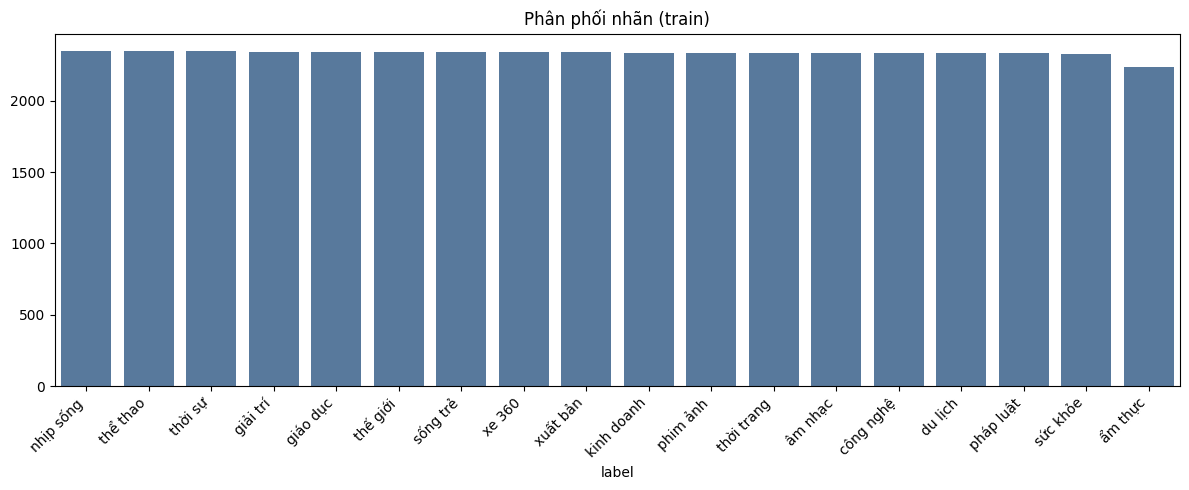

In [22]:
#tập train
plt.figure(figsize=(12,5))
sns.barplot(x=label_counts_train.index, y=label_counts_train.values, color="#4C78A8")
plt.xticks(rotation=45, ha='right')
plt.title("Phân phối nhãn (train)")
plt.tight_layout()
plt.show()


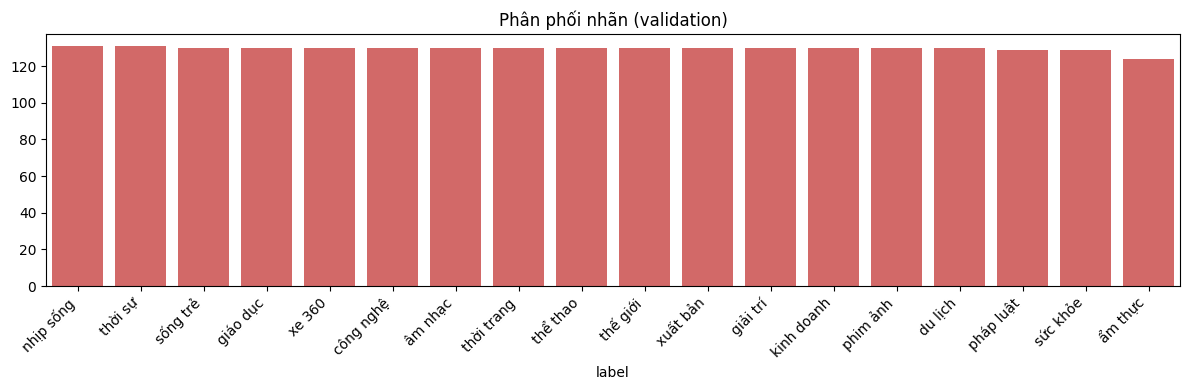

In [23]:
#tập validation
label_counts_val = val_final['label'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(12,4))
sns.barplot(x=label_counts_val.index, y=label_counts_val.values, color="#E45756")
plt.xticks(rotation=45, ha='right')
plt.title("Phân phối nhãn (validation)")
plt.tight_layout()
plt.show()

In [24]:
#Thống kê độ dài văn bản
#đo số lượng ký tự
print("Số lượng char_len (train):")
print(train_final['text_clean'].str.len().describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99]))

Số lượng char_len (train):
count    42010.000000
mean      3169.441109
std       1927.585804
min         84.000000
25%       1844.000000
50%       2736.000000
75%       4056.000000
90%       5525.000000
95%       6631.550000
99%       9296.920000
max      65570.000000
Name: text_clean, dtype: float64


In [25]:
# đo số lượng từ
print("\nSố lượng word_len (train):")
print(train_final['text_clean'].str.split().apply(len).describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99]))


Số lượng word_len (train):
count    42010.000000
mean       549.523851
std        337.619212
min         15.000000
25%        317.250000
50%        470.000000
75%        702.000000
90%        964.000000
95%       1159.000000
99%       1641.000000
max      10637.000000
Name: text_clean, dtype: float64


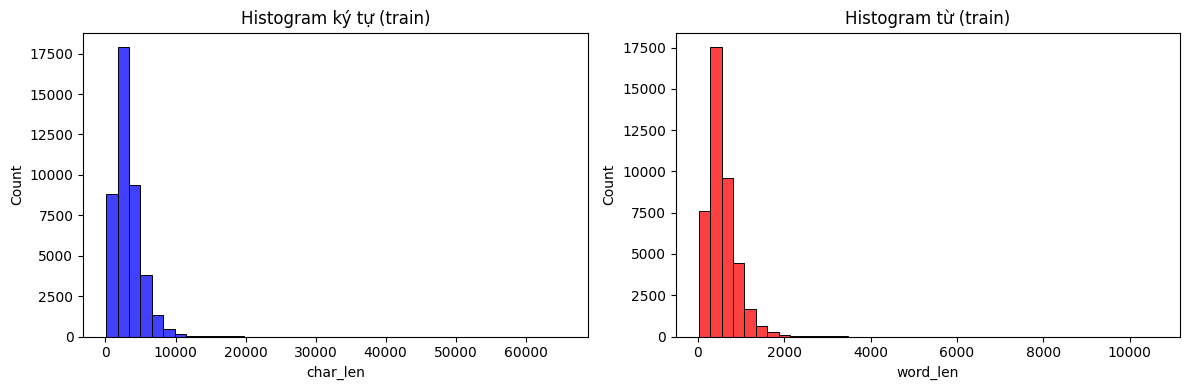

In [26]:
#vẽ biểu đồ
train_final['char_len'] = train_final['text_clean'].str.len()
train_final['word_len'] = train_final['text_clean'].str.split().apply(len)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(train_final['char_len'], bins=40, color="blue")
plt.title("Histogram ký tự (train)")
plt.subplot(1,2,2)
sns.histplot(train_final['word_len'], bins=40, color="red")
plt.title("Histogram từ (train)")
plt.tight_layout()
plt.show()

In [27]:
#Thống kê độ dài theo nhãn
text_col = "text_clean" if "text_clean" in train_final.columns else "text"
train_final = train_final.assign(word_len=train_final[text_col].str.split().apply(len))

len_mean = train_final.groupby("label")["word_len"].mean()
len_median = train_final.groupby("label")["word_len"].median()

print("Độ dài trung bình (word_len) theo nhãn:")
display(len_mean.to_frame("mean_word_len"))

Độ dài trung bình (word_len) theo nhãn:


,mean_word_len
label,
công nghệ,479.588865
du lịch,620.839760
giáo dục,617.440034
giải trí,580.269198
kinh doanh,692.738126
nhịp sống,511.880527
phim ảnh,585.866866
pháp luật,445.858551
sống trẻ,590.939795


In [28]:
print("\nĐộ dài trung vị (word_len) theo nhãn:")
display(len_median.to_frame("median_word_len"))


Độ dài trung vị (word_len) theo nhãn:


,median_word_len
label,
công nghệ,408.0
du lịch,559.5
giáo dục,568.0
giải trí,436.0
kinh doanh,641.0
nhịp sống,491.0
phim ảnh,470.5
pháp luật,344.0
sống trẻ,527.5


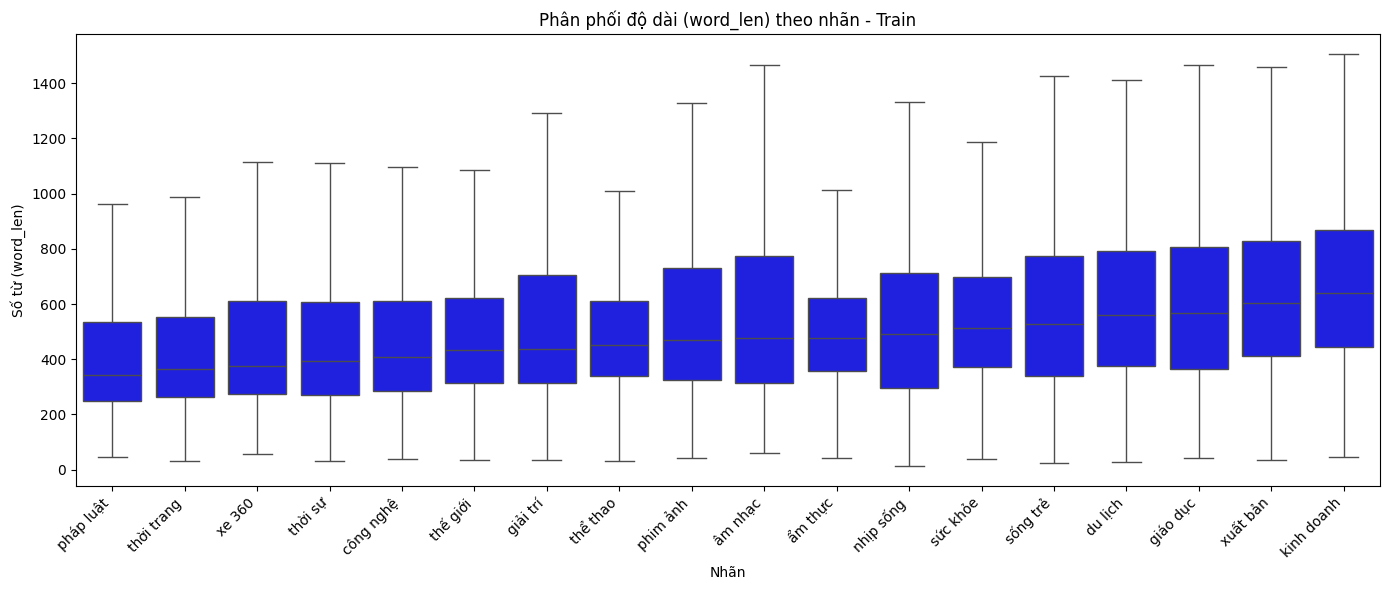

In [29]:
# vẽ biểu đồ
order = train_final.groupby("label")["word_len"].median().sort_values().index

plt.figure(figsize=(14, 6))
sns.boxplot(
    data=train_final,
    x="label", y="word_len",
    order=order,
    showfliers=False,
    color="blue"
)
plt.xticks(rotation=45, ha="right")
plt.title("Phân phối độ dài (word_len) theo nhãn - Train")
plt.ylabel("Số từ (word_len)")
plt.xlabel("Nhãn")
plt.tight_layout()
plt.show()

In [30]:
#N-grams:
from sklearn.feature_extraction.text import CountVectorizer

def top_ngrams(texts, ngram_range=(1,2), top_k=30, min_df=5, max_features=30000):
    vec = CountVectorizer(
        ngram_range=ngram_range,
        min_df=min_df,
        max_features=max_features,
        token_pattern=r"(?u)\b\w+\b" # đếm các từ có 1 ký tự
    )
    X = vec.fit_transform(texts)
    freqs = np.asarray(X.sum(axis=0)).ravel()
    vocab = np.array(vec.get_feature_names_out())
    idx = freqs.argsort()[::-1][:top_k]
    return pd.DataFrame({"ngram": vocab[idx], "freq": freqs[idx]})

top_global = top_ngrams(train_final[text_col].astype(str).tolist(), ngram_range=(1,2), top_k=30, min_df=5)
print("Top 30 n-gram (train):")
display(top_global)

Top 30 n-gram (train):


,ngram,freq
0,của,366919
1,và,352687
2,là,292813
3,trong,242050
4,có,240979
5,được,227602
6,với,217963
7,một,202942
8,các,196851
9,những,196198


# Huấn luyện TF-IDF + LinearSVC
- TF(Term Frequency): Tần suất các từ trong một văn bản
- IDF(Inverse Document Frequency): "Độ hiếm" của từ
- LinearSVC: Linear Support Vector Classification (Tìm đường thẳng qua các điểm)

In [31]:
#TF-IDF + LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report

text_col = "text_clean" if "text_clean" in train_final.columns else "text"

X_train = train_final[text_col].values
y_train = train_final["label_id"].values
X_val   = val_final[text_col].values
y_val   = val_final["label_id"].values
X_test  = test_final[text_col].values
y_test  = test_final["label_id"].values

vectorizer = TfidfVectorizer(
    ngram_range=(1,2),   # đếm từ đơn và cặp từ
    max_features=100000, #giới hạn cụm từ học
    min_df=2,
    sublinear_tf=True,
    token_pattern=r'(?u)\b\w+\b' # từ có 1 ký tự như à, ờ
)


In [32]:
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec   = vectorizer.transform(X_val)
X_test_vec  = vectorizer.transform(X_test)
clf = LinearSVC(class_weight="balanced") #balanced để giảm lệch các features
clf.fit(X_train_vec, y_train)

val_pred = clf.predict(X_val_vec)
test_pred = clf.predict(X_test_vec)

In [33]:
print("Tập Validation:")
print("Validation Accuracy:", accuracy_score(y_val, val_pred))
print("Validation Macro-F1:", f1_score(y_val, val_pred, average="macro"))

print("\nTập Test:")
print("Test Accuracy:", accuracy_score(y_test, test_pred))
print("Test Macro-F1:", f1_score(y_test, test_pred, average="macro"))

Tập Validation:
Validation Accuracy: 0.9755784061696658
Validation Macro-F1: 0.9756123723926255

Tập Test:
Test Accuracy: 0.9747215081405313
Test Macro-F1: 0.9746987285943709


In [34]:
#mapping từ id -> label để rõ hơn
id2label = (
    df_proc_final[["label_id","label"]]
    .drop_duplicates()
    .sort_values("label_id")
    .set_index("label_id")["label"]
    .to_dict()
)

print("\nClassification tập Test:")
print(classification_report(
    y_test, test_pred, target_names=[id2label[i] for i in sorted(id2label.keys())]
))


Classification tập Test:
              precision    recall  f1-score   support

   công nghệ       0.97      0.98      0.98       130
     du lịch       0.96      0.98      0.97       129
    giáo dục       0.97      0.99      0.98       130
    giải trí       0.94      0.98      0.96       130
  kinh doanh       0.99      0.95      0.97       130
   nhịp sống       0.98      0.95      0.96       130
    phim ảnh       0.98      0.98      0.98       130
   pháp luật       0.99      0.98      0.99       130
    sống trẻ       0.97      0.95      0.96       130
    sức khỏe       0.98      0.99      0.98       130
    thế giới       0.95      0.98      0.96       130
    thể thao       1.00      0.97      0.98       131
     thời sự       0.98      0.96      0.97       130
  thời trang       0.98      0.96      0.97       130
      xe 360       0.98      1.00      0.99       130
    xuất bản       0.98      0.98      0.98       130
     âm nhạc       0.98      0.98      0.98       130
 

In [35]:
#Top N-gram theo mô hình đã huấn luyện
feature_names = np.array(vectorizer.get_feature_names_out())
coefs = clf.coef_  # shape: (n_classes, n_features)
print(coefs.shape)

(18, 100000)


In [36]:
#từ/cụm từ có trọng số(weight) cao nhất cho từng nhãn

def top_terms_per_class(coefs, feature_names, top_k=15):
    rows=[]
    for class_idx in range(coefs.shape[0]):
        #lấy hệ số của class
        class_coefs = coefs[class_idx]
        #sắp xếp các trọng số từ thấp đến cao ->dảo ngược->lấy 15 giá trị
        top_pos_idx = np.argsort(class_coefs)[::-1][:top_k]
        for rank, f_idx in enumerate(top_pos_idx, start=1):
            rows.append({
                "label_id": class_idx,
                "label": id2label[class_idx],
                "rank": rank,
                "term": feature_names[f_idx],
                "weight": class_coefs[f_idx]
            })
    return pd.DataFrame(rows)

In [37]:
top_terms_df = top_terms_per_class(coefs, feature_names, top_k=15)
print("Ví dụ 3 lớp đầu:")
display(top_terms_df[top_terms_df["label_id"] < 3].head(45)) # 3 class * 15 từ

Ví dụ 3 lớp đầu:


,label_id,label,rank,term,weight
0,0,công nghệ,1,công_nghệ zing,9.964789
1,0,công nghệ,2,công_nghệ,4.529665
2,0,công nghệ,3,điện_thoại zing,3.931439
3,0,công nghệ,4,người dùng,2.425863
4,0,công nghệ,5,iphone,2.035563
5,0,công nghệ,6,điện_thoại,1.916815
6,0,công nghệ,7,di_động zing,1.739448
7,0,công nghệ,8,apple,1.585348
8,0,công nghệ,9,máy,1.564898
9,0,công nghệ,10,dùng,1.534474


In [38]:
#Huẩn luyện thử mô hình LogisticRegression để so sánh
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(
    penalty="l2", # tránh mô hình overfitting
    C=4.0,
    class_weight="balanced",
    max_iter=200, # số vòng lặp chạy để hội tụ
    n_jobs=-1
)
logreg.fit(X_train_vec, y_train)

val_pred_lr  = logreg.predict(X_val_vec)
test_pred_lr = logreg.predict(X_test_vec)

print("LogReg Validation Macro-F1:", f1_score(y_val, val_pred_lr, average="macro"))
print("LogReg Test Macro-F1:", f1_score(y_test, test_pred_lr, average="macro"))

LogReg Validation Macro-F1: 0.9506430612420844
LogReg Test Macro-F1: 0.9519047177406491


so sánh thấy mô hình LogisticRegression thấp hơn so với TF-IDF+ LinearSVC

In [39]:
import pickle, json

with open("tfidf_vectorizer.pkl","wb") as f:
    pickle.dump(vectorizer, f)
with open("linear_svc_model.pkl","wb") as f:
    pickle.dump(clf, f)
with open("label_mapping.json","w",encoding="utf-8") as f:
    json.dump({"id2label": id2label}, f, ensure_ascii=False, indent=2)


In [40]:
import unicodedata, re

URL_PATH   = re.compile(r'https?://\S+|www\.\S+')
EMAIL_PATH = re.compile(r'\b[\w\.-]+?@\w+?\.\w+?\b')
MULTI_WS   = re.compile(r'\s+')

def clean_text_infer(s: str) -> str:
    if not isinstance(s,str): return ""
    s = unicodedata.normalize("NFC", s)
    s = URL_PATH.sub(" ", s)
    s = EMAIL_PATH.sub(" ", s)
    s = "".join(ch if ch.isprintable() else " " for ch in s)
    s = MULTI_WS.sub(" ", s).strip()
    return s

def predict_texts(texts):
    with open("tfidf_vectorizer.pkl","rb") as fv:
        vec = pickle.load(fv)
    with open("linear_svc_model.pkl","rb") as fm:
        model = pickle.load(fm)
    with open("label_mapping.json","r",encoding="utf-8") as fl:
        id2label_local = json.load(fl)["id2label"]
    cleaned = [clean_text_infer(t) for t in texts]
    X = vec.transform(cleaned)
    pred_ids = model.predict(X)
    return [id2label_local[str(pid)] for pid in pred_ids]

# thử nghiệm
samples = [
    "Đội tuyển Việt Nam giành chiến thắng 2-0 trước đối thủ.",
    "Lãi suất ngân hàng có xu hướng giảm trong quý này."
]
print("Dự đoán:", predict_texts(samples))

Dự đoán: ['thể thao', 'kinh doanh']


# Áp dụng mô hình Transformer (PhoBERT) cho dự đoán

In [41]:
from torch.utils.data import Dataset
from transformers import AutoTokenizer

#chọn cột văn bản
TEXT_COL = "text_clean" if "text_clean" in train_final.columns else "text"

#lấy số nhãn
num_labels = train_final["label_id"].nunique()
print("Số nhãn:", num_labels)

#phoBERT
MODEL_NAME = "vinai/phobert-base-v2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

#Dataset class
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self): # hàm trả về độ dài
        return len(self.texts)
    def __getitem__(self, idx): #hàm lấy 1 mẫu
        encoded = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_len
        )
        # Chuyển output thành tensor
        item = {k: torch.tensor(v, dtype=torch.long) for k, v in encoded.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_ds = NewsDataset(train_final[TEXT_COL].tolist(), train_final["label_id"].tolist(), tokenizer)
val_ds   = NewsDataset(val_final[TEXT_COL].tolist(),   val_final["label_id"].tolist(),   tokenizer)
test_ds  = NewsDataset(test_final[TEXT_COL].tolist(),  test_final["label_id"].tolist(),  tokenizer)

print("Dataset sizes(train):", len(train_ds), "val:", len(val_ds), "test:", len(test_ds))

Số nhãn: 18


config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Dataset sizes(train): 42010 val: 2334 test: 2334


In [42]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)

# Hàm metric
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro")
    }

use_fp16 = torch.cuda.is_available()
# Dùng tập tham số tối thiểu để tương thích phiên bản transformers hiện tại
train_args = TrainingArguments(
    output_dir="phobert_runs",
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=100,
    fp16=use_fp16,
    seed=42,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

print("Bắt đầu fine-tune PhoBERT (1 epoch)...")
train_output = trainer.train()
print("Hoàn tất huấn luyện.")
print(train_output)

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4207024872.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Bắt đầu fine-tune PhoBERT (1 epoch)...


model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

Step,Training Loss
100,2.436200
200,1.338500
300,0.642600
400,0.278300
500,0.146400
600,0.089500
700,0.064800
800,0.048300
900,0.037300
1000,0.030500


Hoàn tất huấn luyện.
TrainOutput(global_step=2626, training_loss=0.20374610683592057, metrics={'train_runtime': 935.4103, 'train_samples_per_second': 44.911, 'train_steps_per_second': 2.807, 'total_flos': 5527441662474240.0, 'train_loss': 0.20374610683592057, 'epoch': 1.0})


In [43]:
print("Đánh giá trên tập validation:")
val_metrics = trainer.evaluate()
print(val_metrics)

print("\nĐánh giá trên tập test:")
test_pred_output = trainer.predict(test_ds)
test_logits = test_pred_output.predictions
test_labels = test_pred_output.label_ids
test_preds = test_logits.argmax(axis=-1)

test_accuracy = accuracy_score(test_labels, test_preds)
test_macro_f1 = f1_score(test_labels, test_preds, average="macro")
print({"test_accuracy": test_accuracy, "test_macro_f1": test_macro_f1})

#
from sklearn.metrics import classification_report
id2label = (
    df_proc_final[["label_id","label"]]
    .drop_duplicates()
    .sort_values("label_id")
    .set_index("label_id")["label"]
    .to_dict()
)
print("\nĐánh giá tập test:")
print(classification_report(test_labels, test_preds,
                            target_names=[id2label[i] for i in sorted(id2label.keys())]))

Đánh giá trên tập validation:


{'eval_loss': 0.006017758511006832, 'eval_accuracy': 1.0, 'eval_macro_f1': 1.0, 'eval_runtime': 18.4058, 'eval_samples_per_second': 126.808, 'eval_steps_per_second': 7.932, 'epoch': 1.0}

Đánh giá trên tập test:
{'test_accuracy': 1.0, 'test_macro_f1': 1.0}

Classification Report (Test):
              precision    recall  f1-score   support

   công nghệ       1.00      1.00      1.00       130
     du lịch       1.00      1.00      1.00       129
    giáo dục       1.00      1.00      1.00       130
    giải trí       1.00      1.00      1.00       130
  kinh doanh       1.00      1.00      1.00       130
   nhịp sống       1.00      1.00      1.00       130
    phim ảnh       1.00      1.00      1.00       130
   pháp luật       1.00      1.00      1.00       130
    sống trẻ       1.00      1.00      1.00       130
    sức khỏe       1.00      1.00      1.00       130
    thế giới       1.00      1.00      1.00       130
    thể thao       1.00      1.00      1.00       131
     thời

In [44]:
import json, os

save_dir = "phobert_model_final"
os.makedirs(save_dir, exist_ok=True)

trainer.save_model(save_dir)          # lưu model + config
tokenizer.save_pretrained(save_dir)

with open(os.path.join(save_dir, "label_mapping.json"), "w", encoding="utf-8") as f:
    json.dump(id2label, f, ensure_ascii=False, indent=2)

In [45]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch, json, unicodedata, re

LOAD_DIR = "phobert_model_final"

infer_tokenizer = AutoTokenizer.from_pretrained(LOAD_DIR)
infer_model = AutoModelForSequenceClassification.from_pretrained(LOAD_DIR)
infer_model.eval()

with open(os.path.join(LOAD_DIR, "label_mapping.json"), "r", encoding="utf-8") as f:
    id2label_loaded = json.load(f)

URL_PAT   = re.compile(r'https?://\S+|www\.\S+')
EMAIL_PAT = re.compile(r'\b[\w\.-]+?@\w+?\.\w+?\b')
MULTI_WS  = re.compile(r'\s+')

def clean_infer(s: str) -> str:
    s = unicodedata.normalize("NFC", s)
    s = URL_PAT.sub(" ", s)
    s = EMAIL_PAT.sub(" ", s)
    s = "".join(ch if ch.isprintable() else " " for ch in s)
    s = MULTI_WS.sub(" ", s).strip()
    return s

def predict_phobert(texts, max_len=256):
    cleaned = [clean_infer(t) for t in texts]
    enc = infer_tokenizer(
        cleaned,
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )
    with torch.no_grad():
        outputs = infer_model(**enc)
        probs = torch.softmax(outputs.logits, dim=-1)
        pred_ids = probs.argmax(dim=-1).tolist()
        pred_labels = [id2label_loaded[str(i)] if isinstance(id2label_loaded, dict) and str(i) in id2label_loaded else id2label_loaded[i] for i in pred_ids]
    return list(zip(pred_labels, probs.max(dim=-1).values.tolist()))

samples = [
    "Đội tuyển Việt Nam giành chiến thắng thuyết phục trước đối thủ.",
    "Lãi suất ngân hàng tiếp tục duy trì ở mức thấp trong quý này."
]

print("Dự đoán:")
for lab, p in predict_phobert(samples):
    print(f"Label: {lab} | Confidence: {p:.4f}")

Dự đoán:
Label: thể thao | Confidence: 0.9925
Label: kinh doanh | Confidence: 0.9871


In [46]:
#phân tích lỗi

errors_mask = test_preds != test_labels
errors_df = test_final.loc[errors_mask, [TEXT_COL, "label_id", "label"]].copy()
errors_df["pred_label_id"] = test_preds[errors_mask]
errors_df["pred_label"] = errors_df["pred_label_id"].map(id2label)
print("Số lỗi:", errors_df.shape[0])
errors_df.head(10)

Số lỗi: 0


,text_clean,label_id,label,pred_label_id,pred_label


*Đánh giá mô hình phoBERT:
- Mô hình mạnh mẽ, hội tụ rất nhanh, loss giảm đều
- Kết quả của mô hình không phải do data leakage, training loss giảm đều, validation loss rất thấp và không tệ khi tăng epochs -> không có dấu hiệu của việc mô hình overfitting